In [215]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

In [216]:
# Генерация случайных данных для 100 транспортных средств
vehicle_classes = np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=20)
imo = np.random.randint(low=9000000, high=9999999, size=20)
speeds = np.random.randint(low=0, high=20, size=20)
start_times = np.random.randint(low=0, high=30, size=20)
end_times = start_times + np.random.randint(low=1, high=30, size=20)
start_points = np.random.randint(low=0, high=3, size=20)
end_points = np.random.randint(low=0, high=4, size=20)
splach_coefficient_values = np.random.randint(low=0, high=10, size=20)

# Создание датасета с сгенерированными данными
vehicle_data = pd.DataFrame({
    'class': vehicle_classes,
    'imo': imo,
    'speed': speeds,
    'start_time': start_times,
    'end_time': end_times,
    'start_point': start_points,
    'end_point': end_points,
    'splach_coefficient_values': splach_coefficient_values
})
# Сохранение датасета в формате CSV
vehicle_data.to_csv('vehicles.csv', index=False)

In [217]:
# Чтение датасета с информацией о транспортных средствах
vehicle_data = pd.read_csv('vehicles.csv')
vehicle_speeds = {}
recommended_start_times = {}
recommended_end_times = {}
start_points = {}
end_points = {}
splach_coefficient_values = {}
for index, row in vehicle_data.iterrows():
    vehicle_class = row['class']
    imo_value = row['imo']
    speed = row['speed']
    start_time = row['start_time']
    end_time = row['end_time']
    start_point = row['start_point']
    end_point = row['end_point']
    splach_coefficient= row['splach_coefficient_values']
    vehicle_speeds[vehicle_class] = speed
    recommended_start_times[vehicle_class] = start_time
    recommended_end_times[vehicle_class] = end_time
    start_points[vehicle_class] = start_point
    end_points[vehicle_class] = end_point
    splach_coefficient_values[vehicle_class] = splach_coefficient

In [218]:
num_routes = len(start_points)
eta_values = 2
print(num_routes)
print(start_points)
# Определение классов транспортных средств и их соответствующих диапазонов баллов сплоченности
vehicle_classes = {
    3: 3,   # класс 0-3
    6: 6,   # класс 0-6
    10: 10  # класс 0-10
}
splach_coefficient = {
    3: 3,   # класс 0-3
    6: 6,   # класс 0-6
    10: 10  # класс 0-10
}

6
{'B': 2, 'F': 2, 'E': 1, 'D': 1, 'C': 1, 'A': 2}


In [219]:
def fitness_function(solution, solution_idx):
    # Разделение генетической популяции на маршруты
    routes = np.split(solution, num_routes, axis=0)
    print(routes)
    # Вычисление значения целевой функции для каждого маршрута
    fitness_values = []
    for route in routes:
        # Добавление начальной точки в маршрут
        print(solution_idx)
        route = np.insert(route, 0, start_point)
        
        # Вычисление значения первого критерия - суммарного отклонения от ETA
        eta_deviations = np.abs(route - eta_values)
        eta_deviation_sum = np.sum(eta_deviations)

        # Вычисление значения второго критерия - суммарного пройденного расстояния
        distance_sum = np.sum(route)

        # Вычисление значения третьего критерия - потери скорости движения
        speed_loss = 0
        for i in range(1, len(route)):
            # Определение класса транспортного средства на основе данных из датасета
            vehicle_class = vehicle_data.loc[i, 'class']


            # Проверка возможности пройти по маршруту выше классом сплоченности
            max_splach_class = splach_coefficient_values[vehicle_class]
            if route[i] > route[i-1] and max_splach_class >= route[i]:
                # Проверяем наличие судна соответствующего класса в караване
                caravan = route[:i]
                if vehicle_class in caravan:
                    continue  # Можем двигаться выше классом сплоченности

            # Вычисление потери скорости на основе класса транспортного средства и погодных условий
            speed = vehicle_speeds[vehicle_class]
            splach_coefficient = splach_coefficient_values[vehicle_class]
            weather_factor = 1 - (splach_coefficient * 0.07)
            distance = route[i] - route[i-1]
            speed_loss += (1 - (speed / 100 * weather_factor)) * distance

        # Учет рекомендуемого времени начала и окончания движения
        start_time = recommended_start_times[vehicle_class]
        end_time = recommended_end_times[vehicle_class]
        time_loss = 0

        # Проверка, находится ли маршрут вне рекомендуемого временного интервала
        if route[1] < start_time or route[-1] > end_time:
            time_loss = 100  # Высокая штрафная функция для маршрутов, не соответствующих рекомендуемым временам

        # Вычисление значения целевой функции
        fitness_value = eta_deviation_sum + distance_sum + speed_loss + time_loss

        # Добавление значения целевой функции в список
        fitness_values.append(fitness_value)

    # Выбор одного значения из списка, например, среднего значения
    fitness_value = np.mean(fitness_values)

    # Возвращение значения целевой функции
    return fitness_value

In [220]:
# Создание экземпляра генетического алгоритма
ga_instance = pygad.GA(
    num_generations=100,  # Количество поколений
    num_parents_mating=10,  # Количество родительских пар для спаривания
    fitness_func=fitness_function,  # Функция приспособленности
    sol_per_pop=50,
    num_genes=num_routes,
    mutation_type=None
)

In [221]:
# Запуск генетического алгоритма
ga_instance.run()

[array([0.60406937]), array([2.45804493]), array([-2.99424549]), array([-0.02340809]), array([-3.8730785]), array([-3.01127385])]
0
0
0
0
0
0
[array([-2.6334938]), array([1.12021683]), array([1.3748892]), array([-1.00733242]), array([1.24230986]), array([1.83788051])]
1
1
1
1
1
1
[array([-0.93153462]), array([3.52990107]), array([3.46113625]), array([-2.82339216]), array([3.22378684]), array([0.94088765])]
2
2
2
2
2
2
[array([-3.76857865]), array([-2.83479104]), array([-1.78182916]), array([1.79618295]), array([3.94354007]), array([-2.21555097])]
3
3
3
3
3
3
[array([-3.98240676]), array([-2.98270538]), array([2.69555968]), array([0.32127676]), array([1.63630362]), array([1.92914392])]
4
4
4
4
4
4
[array([-1.66983259]), array([3.37046769]), array([-1.12393826]), array([3.17428064]), array([-2.05420562]), array([3.20827844])]
5
5
5
5
5
5
[array([-1.54822826]), array([-3.63336758]), array([2.06675456]), array([-0.55953912]), array([-2.88532739]), array([-2.82465037])]
6
6
6
6
6
6
[array([

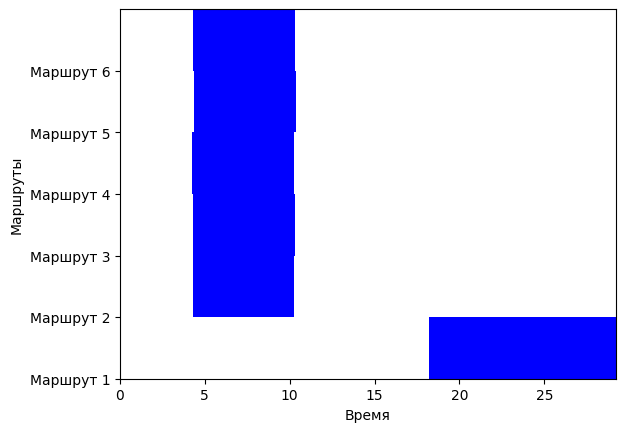

In [222]:
# Визуализация результатов
# Получение лучшего решения из генетического алгоритма
best_solution = ga_instance.best_solution()[0]

# Разделение генетического решения на маршруты
routes = np.split(best_solution, num_routes, axis=0)

# Создание списков для времени начала и окончания каждого маршрута
start_times = []
end_times = []

# Заполнение списков времени начала и окончания каждого маршрута
for route in routes:
    # Добавление начальной точки в маршрут
    route = np.insert(route, 0, start_point)

    # Вычисление времени начала и окончания каждого маршрута
    start_time = recommended_start_times[vehicle_class]
    end_time = recommended_end_times[vehicle_class]

    for i in range(1, len(route)):
        # Определение класса транспортного средства на основе данных из датасета
        vehicle_class = vehicle_data.loc[i, 'class']

        # Проверка возможности пройти по маршруту выше классом сплоченности
        if route[i] > route[i-1]:
            # Проверяем наличие судна соответствующего класса в караване
            caravan = route[:i]
            if vehicle_class in caravan:
                continue  # Можем двигаться выше классом сплоченности

        # Вычисление времени движения на основе класса транспортного средства и расстояния
        speed = vehicle_speeds[vehicle_class]
        distance = route[i] - route[i-1]
        time = distance / speed

        # Вычисление времени начала и окончания каждого маршрута
        start_time += time
        end_time += time

    # Добавление времени начала и окончания в соответствующие списки
    start_times.append(start_time)
    end_times.append(end_time)

# Создание диаграммы Ганта
fig, ax = plt.subplots()

# Отрисовка полос для каждого маршрута
for i in range(len(routes)):
    ax.broken_barh([(start_times[i], end_times[i] - start_times[i])], (i, 1), facecolors='blue')

# Настройка осей и меток
ax.set_ylim(0, len(routes))
ax.set_xlim(0, max(end_times))
ax.set_xlabel('Время')
ax.set_ylabel('Маршруты')
ax.set_yticks(range(len(routes)))
ax.set_yticklabels(['Маршрут {}'.format(i+1) for i in range(len(routes))])

# Отображение диаграммы Ганта
plt.show()

In [223]:
# Формирование данных для JSON
data = {
    "best_solutions": best_solution,
    "best_fitness": best_fitness
}

# Сериализация данных в JSON-строку
json_data = json.dumps(data)

# Отправка JSON-строки
# ...

NameError: name 'best_fitness' is not defined